# Lid Driven 2D Benchmark
http://www.zetacomp.com/benchmarks/lid-driven-cavity-2d.asp

This is a classic benchmark for incompressible Navier-Stokes solvers. The domain is a unit square box, comprising 3 no-slip walls (code 500), and the top "wall" moving with a unit horizontal velocity,no vertical component (code 503). The lid is non-leaky (at the top corner nodes, u=0,v=0 is prescribed). To determine the relative pressure field, a single prescibed value may be needed (semi-implicit only). In which case, P=0 is applied at node 1. This is a forced convection problem, covering a range of Reynolds numbers.

The results for a simple non-uniform structured mesh are presented below. The results are compared to data from Ghia et al (1982) JCP 48:387-411. The horizontal velocity is plotted along the vertical mid-line, with the square datapoints from Ghia et al. Vertical and horizontal contour plots are also provided, along with streamtracer results using ParaView post-processing.

In [1]:
from dolfinx import mesh, fem, io
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np

In [2]:
T = 10 
dt = 1/100
num_steps = int(T/dt)
domain = mesh.create_unit_square(MPI.COMM_WORLD, 50, 50) 

f = (0,0)
mu = 1/1000 # Re = 1/mu (en este caso)
re = 1000
rho = 1

5000 celdas triangulares, como indica el benchmark

In [3]:
domain.geometry.dofmap.shape

(5000, 3)

In [4]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from solver1 import SolverIPCS

solver = SolverIPCS(domain, dt, rho, mu, f)

In [5]:
# lid-driven cavity flow
def lid(x):
    return np.isclose(x[1], 1)

def walls(x):
    return np.logical_or.reduce((np.isclose(x[0], 0), np.isclose(x[0], 1), np.isclose(x[1], 0)))

def corner(x):
    return np.logical_and.reduce((np.isclose(x[0], 0), np.isclose(x[1], 0), np.isclose(x[2], 0)))


fdim = domain.topology.dim - 1

lid_facets = mesh.locate_entities_boundary(domain, fdim, lid)
dofs_lid = fem.locate_dofs_topological(solver.velocity_space, fdim, lid_facets)
bc_lid  = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType((1, 0))), dofs_lid, solver.velocity_space)

walls_facets = mesh.locate_entities_boundary(domain, fdim, walls)
dofs_walls = fem.locate_dofs_topological(solver.velocity_space, fdim, walls_facets)
bc_walls = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType((0, 0))), dofs_walls, solver.velocity_space)

corner_facets = mesh.locate_entities_boundary(domain, fdim, corner)
dofs_corner = fem.locate_dofs_topological(solver.pressure_space, fdim, corner_facets)
bc_p_fix = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType(0)), dofs_corner, solver.pressure_space)

bc_u = [bc_lid, bc_walls]
bc_p = [bc_p_fix]

In [6]:
solver.assembleTimeIndependent(bc_u, bc_p)

In [7]:
def get_tqdm():
    try:
        # Check if inside Jupyter notebook
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        if shell in ["ZMQInteractiveShell"]:
            from tqdm.notebook import tqdm as notebook_tqdm
            return notebook_tqdm
    except:
        pass
    from tqdm import tqdm  # fallback for scripts
    return tqdm

In [8]:
tqdm = get_tqdm()
from datetime import datetime, timezone, timedelta

t = 0
progress = tqdm(desc="Resolviendo navier-stokes", total=num_steps) if domain.comm.rank == 0 else None
folder = datetime.now(tz=timezone(-timedelta(hours=5))).isoformat(timespec='seconds') if domain.comm.rank == 0 else None
folder = domain.comm.bcast(folder, root=0)
u_file = io.VTXWriter(domain.comm, f"{re}re{folder}/velocity.bp", solver.u_sol)
p_file = io.VTXWriter(domain.comm, f"{re}re{folder}/pressure.bp", solver.p_sol)
u_file.write(t)
p_file.write(t)

for n in range(num_steps):
    solver.solveStep(bc_u, bc_p)
    t += dt
    u_file.write(t)
    p_file.write(t)
    
    if progress:
        progress.update()

u_file.close()
p_file.close()
if progress:
    progress.close()

Resolviendo navier-stokes:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
import pandas as pd

data = pd.read_csv(f"./benchmark/plot_u_y_Ghia{re}.csv")
points = np.column_stack((np.array((0.5,) * data["y"].size, dtype=np.float64), data["y"].to_numpy(), np.array((0,) * data["y"].size, dtype=np.float64)))

In [10]:
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells

tree = bb_tree(domain, domain.geometry.dim)
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(domain, cell_candidates, points)

In [11]:
val_sol = np.array([])
val_bench = np.array([])

for (i, p) in enumerate(points):
    val_sol = np.append(val_sol, solver.u_sol.eval(p, colliding_cells.links(i)[:1])[0])
    val_bench = np.append(val_bench, data["u"][i])

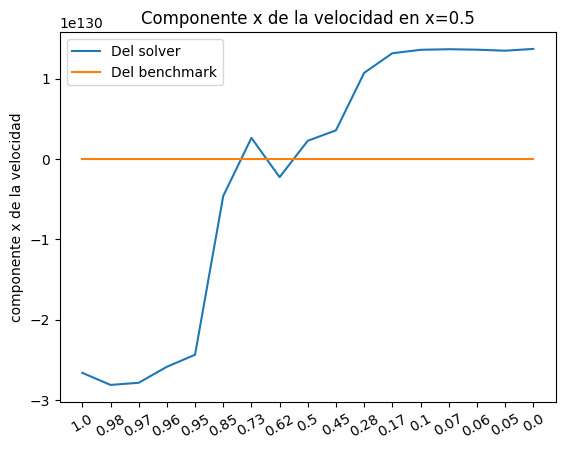

In [12]:
from matplotlib import pyplot as plt

plt.plot(val_sol, label="Del solver")
plt.plot(val_bench, label="Del benchmark")
plt.legend()
plt.ylabel("componente x de la velocidad")
plt.xticks(np.arange(data["y"].size), map(lambda x: round(x, 2),data["y"].to_list()), rotation=30)
plt.title("Componente x de la velocidad en x=0.5")
plt.show()